the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60174.979820 from DATE-END'. [astropy.wcs.wcs]


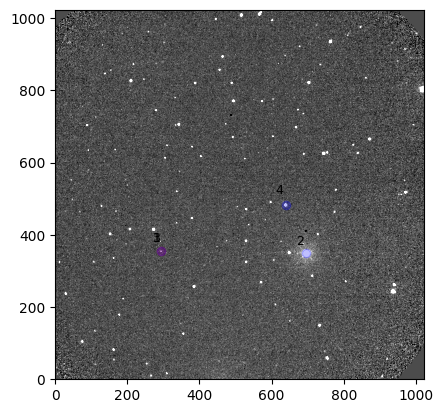

In [5]:
import os
import pandas as pd
from photometry import Photometry
from scripts.tools import sort_files
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from photometry import Photometry
from copy import copy

star_name = "GRB 230818A"
experiment = "first rotor position"
_set = "first"
camera = 3
max_box_size = 30
src_path = os.path.join(
    "..",
    "Pol charact MOPTOP",
    "Scientific objects",
    star_name,
    experiment,
    f"{_set} set",
    star_name,
)

GOOD_IMAGE = {
    "first_cam3": "3_e_20230818_5_1_1_1.fits",
    "second_cam3": "",
    "first_cam4": "cam4_run1.fits",
    "second_cam4": "",
}
file = os.path.join(src_path, GOOD_IMAGE[f"{_set}_cam{camera}"])
image = fits.getdata(file)
median = np.median(image)
std = np.median(np.abs(image - median))
plt.imshow(
    image, vmax=median + 7 * std, vmin=median - 3 * std, origin="lower", cmap="gray"
)

csv_file = os.path.join(src_path, "..", f"objects coordinates.csv")
df = pd.read_csv(csv_file)
objects = {
    "name": df["name"],
    "ra": df[f"ra_{_set}_set_cam{camera}"],
    "dec": df[f"dec_{_set}_set_cam{camera}"],
}
objects = pd.DataFrame.from_dict(objects)
phot = Photometry(file, objects, max_box_size)
phot.reset_object_coords()
for idx, _object in enumerate(phot.obj_list):
    name, x, y, *_ = _object.get_info()
    color = "b"
    if name == "original":
        color = "r"
    plt.plot(x, y, f"{color}o", alpha=0.25)
    plt.annotate(f"{idx+1}", (x * 0.99, y * 1.05), ha="right", va="bottom", fontsize=9)

plt.show()

# Create photometry.csv

In [7]:
objects_photometry = {}
for obj_name in objects["name"]:
    objects_photometry[obj_name] = {
        "mjd": [],
        "xcoord": [],
        "ycoord": [],
        "psf_radius": [],
        "star_photons": [],
        "star_error": [],
    }


image_list = sort_files(src_path, f"3_e")
for file in image_list:
    file_path = os.path.join(src_path, file)

    phot = Photometry(file_path, objects, max_box_size)
    phot.reset_object_coords()
    phot.calc_psf_radius()
    phot.calc_sky_photons()
    phot.calc_psf_photons()

    for _object in phot.obj_list:
        (
            name,
            xcoord,
            ycoord,
            mjd,
            psf_radius,
            *_,
            star_photons,
            star_err,
        ) = _object.get_info()
        objects_photometry[name]["mjd"].append(mjd)
        objects_photometry[name]["xcoord"].append(xcoord)
        objects_photometry[name]["ycoord"].append(ycoord)
        objects_photometry[name]["psf_radius"].append(psf_radius)
        objects_photometry[name]["star_photons"].append(star_photons)
        objects_photometry[name]["star_error"].append(star_err)


for obj_name, obj_info in objects_photometry.items():
    df = pd.DataFrame.from_dict(obj_info)
    csv_file = os.path.join(src_path, "..", "csv", f"{obj_name}_cam{camera}.csv")
    df.sort_values(by=["mjd"])
    df.to_csv(csv_file, index=False)

Set MJD-END to 60174.980746 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.981672 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.982598 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.983524 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.984450 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.985376 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.986302 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.988154 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.989080 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.991857 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.992783 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.993709 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.996487 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60174.997413 from DATE-END'. [astropy.wcs.wcs]


# Plot light curve

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt

star_name = "GRB 230818A"
experiment = "first rotor position"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)


def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c


def read_csv_files():
    cand, comp_1 = [], []
    for _set in ["first"]:
        csv_path = os.path.join(src_path, f"{_set} set", "csv")
        csv_file = os.path.join(csv_path, f"comparison_1_cam{camera}.csv")
        comp_1.append(pd.read_csv(csv_file))
        csv_file = os.path.join(csv_path, f"candidate_1_cam{camera}.csv")
        cand.append(pd.read_csv(csv_file))

    df = pd.concat(cand, axis=0, ignore_index=True)
    cand = df["star_photons"]
    cand_err = df["star_error"]
    df = pd.concat(comp_1, axis=0, ignore_index=True)
    comp_1 = df["star_photons"]
    comp_1_err = df["star_error"]

    norm_cand = cand / comp_1
    cand_err = np.abs(norm_cand) * np.sqrt(
        (cand_err / cand) ** 2 + (comp_1_err / comp_1) ** 2
    )

    median = np.median(norm_cand)
    norm_cand /= median
    cand_err /= median
    mjd = df["mjd"]
    mjd -= mjd[0]

    return norm_cand, cand_err, mjd


def calc_adjust(x, y):
    params, _ = scipy.optimize.curve_fit(monoExp, x, y)
    a, b, c = params
    exp_adjust = monoExp(x, a, b, c)
    return exp_adjust, a, b, c


cand, err, mjd = read_csv_files()

fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharey="row", sharex="col")
for camera in [3]:
    cand, cand_err, mjd = read_csv_files()
    exp_adjust, a, b, c = calc_adjust(mjd, cand)

    # --------------------------------------------------------------
    ax = axs[0, camera - 3]
    ax.errorbar(
        mjd, cand, cand_err, marker="o", color="b", alpha=0.4, label="data", ls="none"
    )

    ax.plot(mjd, exp_adjust, "b-", label="exponential adjustment")
    ax.set_title(f"camera {camera}: f(x) = {a:.2f}*e^({-b:.2f})+{c:.2f}")
    ax.legend()

    # --------------------------------------------------------------
    ax = axs[1, camera - 3]
    residuals = cand - exp_adjust
    mean = np.mean(residuals)
    std = np.std(residuals)

    ax.errorbar(
        mjd,
        residuals,
        cand_err,
        marker="o",
        color="b",
        alpha=0.4,
        label="data",
        ls="none",
    )

    # --------------------------------------------------------------

    ax.set_ylabel("Residuals")
    ax.axhline(mean, color="r", linestyle="--", alpha=0.75)
    ax.set_ylim(mean - 7 * std, mean + 7 * std)
    ax.set_xlabel("Time since the first image (MJD)")
    ax.annotate(
        f"mean of the residuals: {mean:.2e}\nresiduals std: {std:.2f}\nmean photometry error: {np.mean(cand_err):.2f}",
        (0.05, 0.95),
        fontsize=10,
        ha="left",
        va="top",
        xycoords="axes fraction",
    )

plt.savefig(os.path.join(src_path, "light_curve.png"))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../Pol charact MOPTOP/Scientific objects/GRB 230818A/first rotor position/GRB 230818A/first set/csv/comparison_1_cam3.csv'

# Plot object coordinates over the image

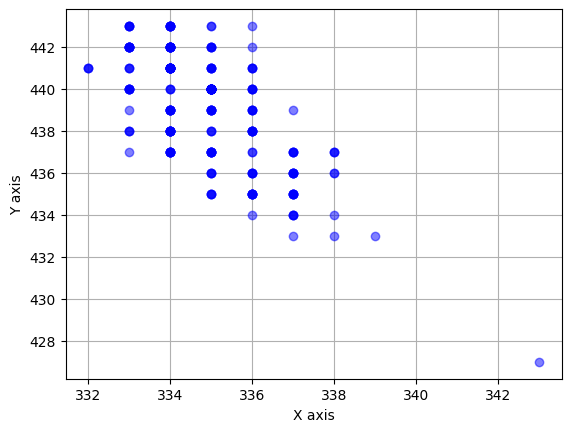

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import os

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)

csv_file = os.path.join(src_path, "csv", "first set", "candidate_1_cam3.csv")
df = pd.read_csv(csv_file)
plt.plot(df["xcoord"], df["ycoord"], "bo", alpha=0.5)
# plt.xlim(0, 1024)
# plt.ylim(0, 1024)
plt.xlabel(("X axis"))
plt.ylabel("Y axis")
plt.grid()
plt.show()

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import scipy
from math import sqrt

star_name = "GRB 230818A"
experiment = "all data"
src_path = os.path.join(
    "..", "Pol charact MOPTOP", "Scientific objects", star_name, experiment
)


def read_csv_files():
    cand, comp_1 = [], []
    for _set in ["first"]:
        csv_path = os.path.join(src_path, f"{_set} set", "csv")
        csv_file = os.path.join(csv_path, f"comparison_1_cam{camera}.csv")
        comp_1.append(pd.read_csv(csv_file))
        csv_file = os.path.join(csv_path, f"candidate_1_cam{camera}.csv")
        cand.append(pd.read_csv(csv_file))

    df = pd.concat(cand, axis=0, ignore_index=True)
    cand = df["star_photons"]
    cand_err = df["star_error"]
    df = pd.concat(comp_1, axis=0, ignore_index=True)
    comp_1 = df["star_photons"]
    comp_1_err = df["star_error"]

    norm_cand = cand / comp_1
    cand_err = np.abs(norm_cand) * np.sqrt(
        (cand_err / cand) ** 2 + (comp_1_err / comp_1) ** 2
    )

    median = np.median(cand)
    cand /= median
    cand_err /= median
    mjd = df["mjd"]
    mjd -= mjd[0]

    return norm_cand, cand_err, mjd


cand, err, mjd = read_csv_files()

0     0.001282
1     0.000890
2     0.000701
3     0.000439
4     0.000389
5     0.000406
6     0.000583
7     0.000430
8     0.000056
9     0.000303
10    0.000007
11    0.000035
12   -0.000041
13    0.000270
14    0.000044
15   -0.000078
16    0.000238
17    0.000046
18    0.000179
19    0.000149
Name: star_photons, dtype: float64
